In [48]:
# Import external modules
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
# Import internal modules
from data.clean_data import df
from utils.helpers import prepare_eurusd_data
from utils.helpers import train_test_split

In [50]:
df.head()

,datetime,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close
96,2020-01-02 00:00:00,1.12184,1.12186,1.12156,1.12157,1.12198,1.12199,1.12167,1.12168
97,2020-01-02 00:15:00,1.12154,1.12164,1.12151,1.12155,1.12168,1.12177,1.12165,1.12169
98,2020-01-02 00:30:00,1.12157,1.12169,1.12152,1.12167,1.12169,1.12182,1.12164,1.12181
99,2020-01-02 00:45:00,1.12169,1.12183,1.12169,1.12178,1.12181,1.12197,1.12181,1.12191
100,2020-01-02 01:00:00,1.12177,1.12225,1.12176,1.12221,1.12190,1.12238,1.12188,1.12234


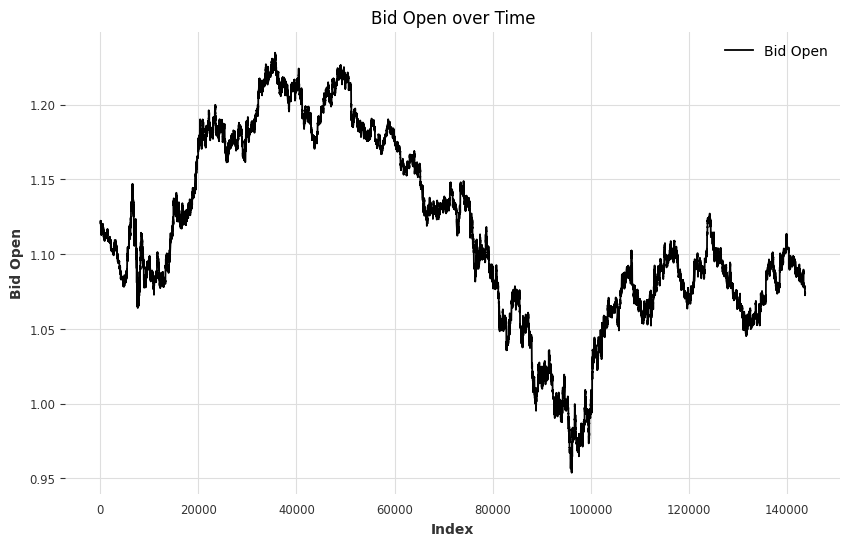

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot 'bid_open' as a line plot
plt.figure(figsize=(10, 6))
# Plotting index instead of datetime, since Nan removal leads to inconsistent spacing
plt.plot(df.index, df['bid_open'], label='Bid Open', color='black')
plt.title('Bid Open over Time')
plt.xlabel('Index')
plt.ylabel('Bid Open')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Prepare EURUSD data and make suitable subselection
series, target_series, cov_series, dates = prepare_eurusd_data(data=df, n=1000)

c:\Users\Paul\Desktop\Repositories\Time-Series-Ensembles\project\utils\helpers.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('datetime', axis=1, inplace=True)


<Axes: xlabel='time'>

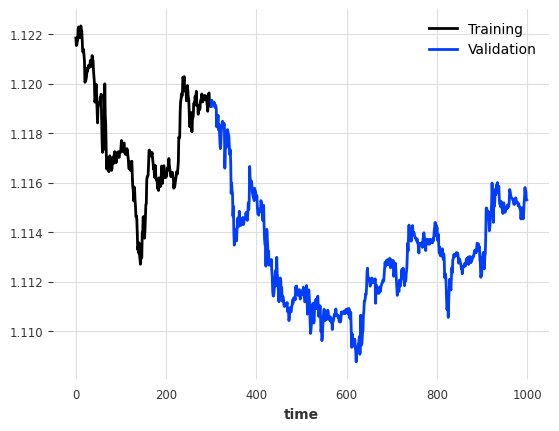

In [53]:
train, val = train_test_split(target_series)

# Plotting prepared univariate series (subselection)
train.plot(label='Training')
val.plot(label='Validation')

In [54]:
from pipeline.models_darts_univ import univariate_models
from pipeline.models_darts_univ import hfc_models

# Print univariate model pool
print(f'Models:\n {univariate_models}')

# Historically train univariate models
historical_forecasts = hfc_models(univariate_models, target_series)

Models:
 [NaiveMovingAverage(input_chunk_length=1), NaiveDrift(), XGBModel(lags=12, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)]
Training NaiveMovingAverage:


  0%|          | 0/701 [00:00<?, ?it/s]

Training NaiveDrift:


  0%|          | 0/701 [00:00<?, ?it/s]

Training XGBModel:


  0%|          | 0/701 [00:00<?, ?it/s]

In [56]:
from utils.helpers import timeseries_to_array

# Retrieve target values
target_values = timeseries_to_array(val, pop=False)

# Add Target column to dataframe
historical_forecasts.insert(0, 'Target', target_values)

In [59]:
historical_forecasts.head()

,Target,NaiveMovingAverage,NaiveDrift,XGBModel
0,1.11908,1.11913,1.119121,1.119230
1,1.11933,1.11908,1.119071,1.119102
2,1.11925,1.11908,1.119071,1.119102
3,1.11923,1.11933,1.119322,1.119353
4,1.11917,1.11925,1.119241,1.119266


In [ ]:
from utils.metrics import rmse
from utils.ensembling_methods import *

In [ ]:
simple_average(historical_forecasts)

0      1.119160
1      1.119084
2      1.119084
3      1.119335
4      1.119253
         ...   
695    1.115135
696    1.115385
697    1.115727
698    1.115518
699    1.115577
Length: 700, dtype: float64

In [60]:
compute_rmse_weights(historical_forecasts)

{'NaiveMovingAverage': 0.346221748087165,
 'NaiveDrift': 0.3461919338545404,
 'XGBModel': 0.30758631805829467}

In [80]:
import numpy as np

def compute_rmse_weighted_predictions(data):
    """
    Computes RMSE-weighted predictions for the entire DataFrame.

    Parameters:
        data (DataFrame): DataFrame containing actual values and predictions from different models.

    Returns:
        numpy.ndarray: RMSE-weighted predictions for the entire DataFrame.
    """
    # Initialize an empty array to store predictions
    weighted_predictions = []

    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        # Extract target value for the current row
        target = row['Target']
        
        # Compute RMSE for each model for the current row
        rmse_values = {model: np.sqrt(np.mean((target - row[model]) ** 2)) for model in row.index[1:]}
        
        # Compute weights inversely proportional to RMSE for the current row
        total_rmse = sum(rmse_values.values())
        weights = {model: 1 / (rmse_val + 1e-20) for model, rmse_val in rmse_values.items()}  # Adding a small value to avoid division by zero
        
        # Normalize weights to sum up to 1
        total_weight = sum(weights.values())
        print(f'Total weights: {total_weight}')
        normalized_weights = {model: weight / total_weight for model, weight in weights.items()}
        print(f'Normalized weights: {normalized_weights}')
        print(f'Sum of Normalized weights: {sum(normalized_weights.values())}')
        
        # Compute weighted prediction for the current row
        weighted_prediction = sum([row[model] * weight for model, weight in normalized_weights.items()])
        
        # Append the weighted prediction to the list
        weighted_predictions.append(weighted_prediction)

    return np.array(weighted_predictions)

# Example usage
# Assuming `historical_forecasts` is your DataFrame
predictions = compute_rmse_weighted_predictions(historical_forecasts)
print(predictions)


Total weights: 51100.93857775669
Normalized weights: {'NaiveMovingAverage': 0.39138224378430975, 'NaiveDrift': 0.47839174999012896, 'XGBModel': 0.1302260062255613}
Sum of Normalized weights: 1.0
Total weights: 12241.262555718567
Normalized weights: {'NaiveMovingAverage': 0.32676367995502204, 'NaiveDrift': 0.31512817799817, 'XGBModel': 0.358108142046808}
Sum of Normalized weights: 1.0
Total weights: 18203.23321613576
Normalized weights: {'NaiveMovingAverage': 0.32314879842126615, 'NaiveDrift': 0.3065585699308162, 'XGBModel': 0.37029263164791765}
Sum of Normalized weights: 1.0
Total weights: 29059.820343903957
Normalized weights: {'NaiveMovingAverage': 0.34411775027022345, 'NaiveDrift': 0.37542385948313406, 'XGBModel': 0.28045839024664254}
Sum of Normalized weights: 1.0
Total weights: 36875.36123706566
Normalized weights: {'NaiveMovingAverage': 0.3389797301137484, 'NaiveDrift': 0.37968244225966497, 'XGBModel': 0.2813378276265866}
Sum of Normalized weights: 1.0
Total weights: 653633.99887

In [107]:
def compute_rmse_weighted_predictions(data, target_column = 'Target'):
    """
    Computes RMSE-weighted predictions for the entire DataFrame.

    Parameters:
        data (DataFrame): DataFrame containing actual values and predictions from different models.

    Returns:
        numpy.ndarray: RMSE-weighted predictions for the entire DataFrame.
    """
    # Initialize an empty array to store predictions
    weighted_predictions = []
    
    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        
        # Compute RMSE for each model for the current row
        # Add small value to avoid division by 0
        inverse_rmse_values = {model: 1/rmse(row[target_column], row[model]) for model in row.index[1:]}

        # Compute Sum of inverse rmse values
        sum_of_inverse_error = sum(inverse_rmse_values.values())

        # compute model weights
        weights = {model: value / sum_of_inverse_error for model, value in inverse_rmse_values.items()}

    return weights

compute_rmse_weighted_predictions(historical_forecasts)

C:\Users\Paul\AppData\Local\Temp\ipykernel_16900\1577375961.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  inverse_rmse_values = {model: 1/rmse(row[target_column], row[model]) for model in row.index[1:]}
C:\Users\Paul\AppData\Local\Temp\ipykernel_16900\1577375961.py:25: RuntimeWarning: invalid value encountered in scalar divide
  weights = {model: value / sum_of_inverse_error for model, value in inverse_rmse_values.items()}


{'NaiveMovingAverage': 0.25813056432954995,
 'NaiveDrift': 0.26309645901514456,
 'XGBModel': 0.47877297665530544}

In [108]:
import numpy as np

def compute_rmse_weighted_predictions(data, target_column='Target'):
    """
    Computes RMSE-weighted predictions for the entire DataFrame.

    Parameters:
        data (DataFrame): DataFrame containing actual values and predictions from different models.

    Returns:
        numpy.ndarray: RMSE-weighted predictions for the entire DataFrame.
    """
    # Initialize an empty dictionary to store weights
    weights = {}

    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        # Compute RMSE for each model for the current row
        rmse_values = {model: rmse(row[target_column], row[model]) for model in row.index[1:]}

        # Remove any NaN values from rmse_values
        rmse_values = {model: value for model, value in rmse_values.items() if not np.isnan(value)}

        # Check if any RMSE value is zero, if so, set it to a small non-zero value
        rmse_values = {model: value if value != 0 else 1e-10 for model, value in rmse_values.items()}

        # Compute inverse RMSE values
        inverse_rmse_values = {model: 1 / value for model, value in rmse_values.items()}

        # Compute the sum of inverse RMSE values
        sum_of_inverse_error = sum(inverse_rmse_values.values())

        # Compute model weights
        weights_row = {model: value / sum_of_inverse_error for model, value in inverse_rmse_values.items()}

        # Update weights dictionary with weights for current row
        weights[index] = weights_row

    return weights

# Example usage
weights = compute_rmse_weighted_predictions(historical_forecasts)
print(weights)


{0: {'NaiveMovingAverage': 0.3913822437843098, 'NaiveDrift': 0.47839174999012896, 'XGBModel': 0.13022600622556127}, 1: {'NaiveMovingAverage': 0.32676367995502204, 'NaiveDrift': 0.31512817799817, 'XGBModel': 0.358108142046808}, 2: {'NaiveMovingAverage': 0.32314879842126615, 'NaiveDrift': 0.3065585699308162, 'XGBModel': 0.37029263164791765}, 3: {'NaiveMovingAverage': 0.34411775027022345, 'NaiveDrift': 0.3754238594831341, 'XGBModel': 0.28045839024664254}, 4: {'NaiveMovingAverage': 0.33897973011374843, 'NaiveDrift': 0.379682442259665, 'XGBModel': 0.28133782762658666}, 5: {'NaiveMovingAverage': 0.025498469625799068, 'NaiveDrift': 0.029772779563097224, 'XGBModel': 0.9447287508111037}, 6: {'NaiveMovingAverage': 0.3525615172258215, 'NaiveDrift': 0.31768418299127327, 'XGBModel': 0.3297542997829051}, 7: {'NaiveMovingAverage': 0.3576566407172325, 'NaiveDrift': 0.29343719009759894, 'XGBModel': 0.3489061691851686}, 8: {'NaiveMovingAverage': 0.33358007033575454, 'NaiveDrift': 0.3475896760137185, 'XG

In [109]:
import pandas as pd
import numpy as np

def compute_rmse_weighted_predictions(data, target_column='Target'):
    """
    Computes RMSE-weighted predictions for the entire DataFrame.

    Parameters:
        data (DataFrame): DataFrame containing actual values and predictions from different models.

    Returns:
        DataFrame: DataFrame containing RMSE-weighted predictions for each model in each row.
    """
    # Initialize an empty DataFrame to store weights
    weights_df = pd.DataFrame()

    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        # Compute RMSE for each model for the current row
        rmse_values = {model: rmse(row[target_column], row[model]) for model in row.index[1:]}

        # Remove any NaN values from rmse_values
        rmse_values = {model: value for model, value in rmse_values.items() if not np.isnan(value)}

        # Check if any RMSE value is zero, if so, set it to a small non-zero value
        rmse_values = {model: value if value != 0 else 1e-10 for model, value in rmse_values.items()}

        # Compute inverse RMSE values
        inverse_rmse_values = {model: 1 / value for model, value in rmse_values.items()}

        # Compute the sum of inverse RMSE values
        sum_of_inverse_error = sum(inverse_rmse_values.values())

        # Compute model weights
        weights_row = {model: value / sum_of_inverse_error for model, value in inverse_rmse_values.items()}

        # Append weights for current row to the DataFrame
        weights_df = weights_df.append(pd.Series(weights_row, name=index))

    return weights_df

# Example usage
weights_df = compute_rmse_weighted_predictions(historical_forecasts)
print(weights_df)


AttributeError: 'DataFrame' object has no attribute 'append'